In [137]:
import pandas as pd
import numpy as np

# Визуализация
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
%matplotlib inline

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve, f1_score

from itertools import combinations # itertools - сборник полезных итераторов
from scipy.stats import ttest_ind

In [2]:
# фиксируем RANDOM_SEED
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
import warnings
warnings.filterwarnings("ignore")

## Data

In [5]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

Проверим количество дефолтов в модели для обучения

In [6]:
df_train['default'].value_counts()

0    64427
1     9372
Name: default, dtype: int64

Выборка является несбалансированной.

In [7]:
# объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['default'] = 0 # в тесте у нас нет значения default, мы его должны предсказать, по этому пока просто заполняем нулями

In [8]:
data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [10]:
data.describe()

,client_id,age,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,sample,default
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,55074.500000,39.249410,0.273205,0.165514,-1.904535,2.005002,56.751189,1.574945,2.497867,41012.648537,1.731588,2.765570,0.669999,0.085086
std,31797.133063,11.518063,0.799099,0.371645,0.499397,2.266926,13.065923,0.527562,0.687651,45399.735051,1.122652,1.010151,0.470215,0.279010
min,1.000000,21.000000,0.000000,0.000000,-3.624586,0.000000,20.000000,1.000000,1.000000,1000.000000,1.000000,1.000000,0.000000,0.000000
25%,27537.750000,30.000000,0.000000,0.000000,-2.260434,0.000000,50.000000,1.000000,2.000000,20000.000000,1.000000,2.000000,0.000000,0.000000
50%,55074.500000,37.000000,0.000000,0.000000,-1.920823,1.000000,50.000000,2.000000,3.000000,30000.000000,1.000000,3.000000,1.000000,0.000000
75%,82611.250000,48.000000,0.000000,0.000000,-1.567888,3.000000,60.000000,2.000000,3.000000,48000.000000,2.000000,4.000000,1.000000,0.000000
max,110148.000000,72.000000,33.000000,1.000000,0.199773,53.000000,80.000000,3.000000,3.000000,1000000.000000,4.000000,4.000000,1.000000,1.000000


In [11]:
data.sample(5)

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,sample,default
17191,8908,16JAN2014,SCH,F,60,N,N,0,1,-2.036936,2,60,2,3,15000,2,1,N,0,0
4325,47591,24FEB2014,GRD,F,22,N,N,0,0,-2.422398,2,70,2,3,25000,4,3,N,0,0
58981,9011,16JAN2014,SCH,F,31,N,N,5,0,-1.854299,1,40,2,3,20000,2,2,N,1,1
28975,36790,12FEB2014,GRD,F,56,N,N,1,0,-1.465227,2,50,2,3,16000,1,3,N,0,0
30803,53066,01MAR2014,UGR,F,48,N,N,0,1,-2.285150,3,50,1,3,35000,1,4,N,0,0


Описания полей

    client_id - идентификатор клиента
    education - уровень образования
    sex - пол заемщика 
    age - возраст заемщика 
    car - флаг наличия автомобиля 
    car_type - флаг автомобиля иномарки 
    decline_app_cnt - количество отказанных прошлых заявок 
    good_work - флаг наличия “хорошей” работы
    bki_request_cnt - количество запросов в БКИ 
    home_address - категоризатор домашнего адреса
    work_address - категоризатор рабочего адреса
    income - доход заемщика
    foreign_passport - наличие загранпаспорта
    sna - связь заемщика с клиентами банка
    first_time - давность наличия информации о заемщике
    score_bki - скоринговый балл по данным из БКИ
    region_rating - рейтинг региона
    app_date - дата подачи заявки 
    default - флаг дефолта по кредиту - целевая переменная
    sample - принадлнжность к данным для обучения - метка (в анализе не участвует)

In [12]:
# Тип переменных
# Числовые переменные
num_cols = ['age','score_bki', 'decline_app_cnt', 'bki_request_cnt', 'income', 'region_rating']
# Переменные времени
# app_date
# Категориальные переменные
cat_cols = ['education', 'home_address', 'work_address', 'first_time', 'sna']
# Бинарные переменные
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

# Работа с данными

## Числовые переменные

In [13]:
data[num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   age              110148 non-null  int64  
 1   score_bki        110148 non-null  float64
 2   decline_app_cnt  110148 non-null  int64  
 3   bki_request_cnt  110148 non-null  int64  
 4   income           110148 non-null  int64  
 5   region_rating    110148 non-null  int64  
dtypes: float64(1), int64(5)
memory usage: 5.0 MB


In [14]:

data[num_cols].describe()

,age,score_bki,decline_app_cnt,bki_request_cnt,income,region_rating
count,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000,110148.000000
mean,39.249410,-1.904535,0.273205,2.005002,41012.648537,56.751189
std,11.518063,0.499397,0.799099,2.266926,45399.735051,13.065923
min,21.000000,-3.624586,0.000000,0.000000,1000.000000,20.000000
25%,30.000000,-2.260434,0.000000,0.000000,20000.000000,50.000000
50%,37.000000,-1.920823,0.000000,1.000000,30000.000000,50.000000
75%,48.000000,-1.567888,0.000000,3.000000,48000.000000,60.000000
max,72.000000,0.199773,33.000000,53.000000,1000000.000000,80.000000


В данных отсутствуют пропуски. Тип данных: 5 столбцов c целочиcленными данными, один столбец - с дробными 
Проверим распределение числовых данных и наличие выбросов.

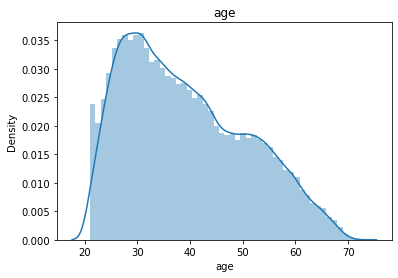

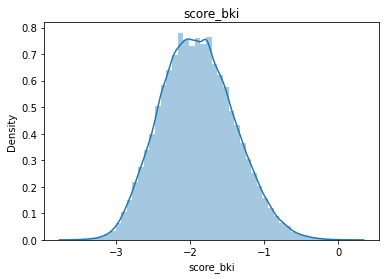

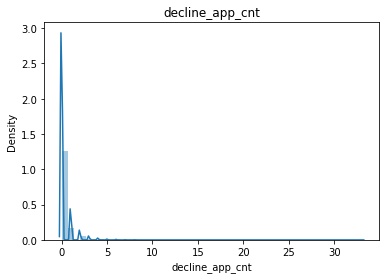

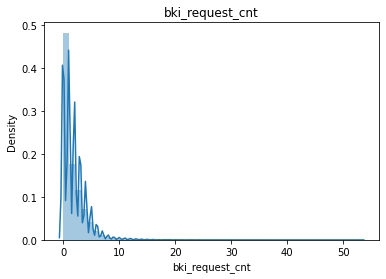

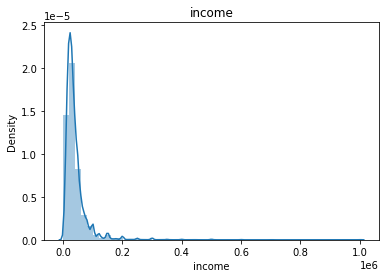

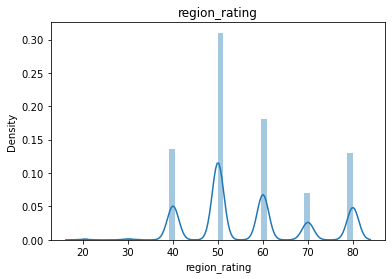

In [15]:
# Распределение данных
for i in data[num_cols]:
    plt.figure()
    sns.distplot(data[i], kde = True, rug = False)
    plt.title(i)
    plt.show()

Данные в столбце region_rating

In [16]:
# Проверим количество уникальных значений в столбце region_rating
data['region_rating'].unique()

array([50, 40, 80, 60, 70, 20, 30])

В столбце region_rating 7 уникальных значений. В данном случае можно перевести данные в категориальный тип.

In [17]:
num_cols.remove('region_rating')
cat_cols.append('region_rating')

#### Данные в столбце score_bki
Из графика видно, что распределение данных похоже на нормальное распределение. 

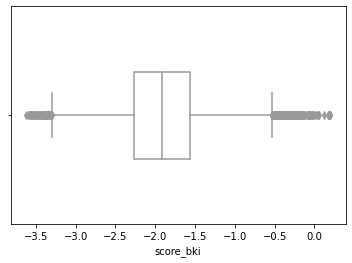

In [18]:
sns.boxplot(data['score_bki'], color = 'w', width= 0.4)

В столбце score_bki присутствуют положительные и отрицательные значения.  
Данные, выходящие за [Q1 - 1,5 * IQR ; Q3 + 1,5 * IQR], оставим без изменений

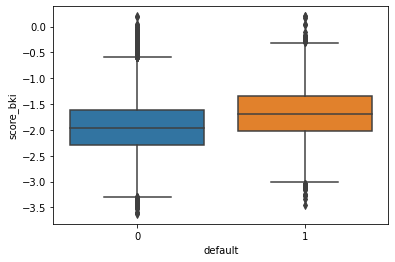

In [19]:
sns.boxplot( x = 'default', y = 'score_bki', data = df_train)

С учетом того, что выборка является несбалансированной (количество без дефолта, больше чем с дефолтом), примем, что чем больше score_bki, тем меньше вероятность того, что у клиента появится дефолт по кредиту. Изменим знак для всех отрицательных значений.

In [20]:
data['score_bki'] = data['score_bki'].apply(lambda x: -1*x if x < 0  else x)

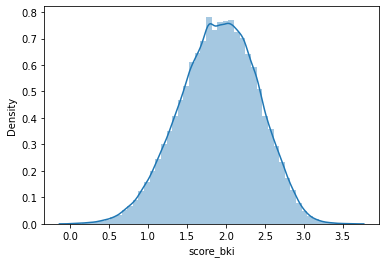

In [21]:
sns.distplot(data['score_bki'], kde = True, rug = False)

#### Данные в столбце age

Данные не имеют явных выбросов (минимальный возраст 21 год, максимальный - 72 года).
Распределение данных имеет тяжелый правый хвост. Прологарифмируем данные в столбце age, чтобы приблизить распределение к нормальному

In [22]:
data['age'] = data['age'].apply(lambda x : np.log(x))

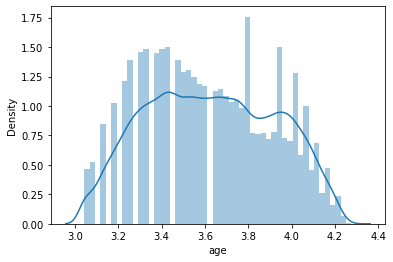

In [23]:
sns.distplot(data['age'], kde = True, rug = False)

Оставим данные, после логарифмирования. 

#### Данные в столбцах decline_app_cnt и bki_request_cnt

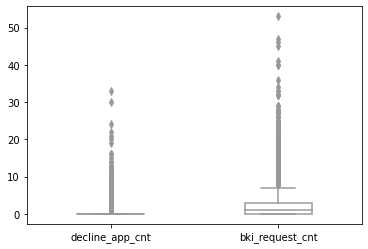

In [24]:
sns.boxplot(data = data[['decline_app_cnt', 'bki_request_cnt']], color = 'w', width= 0.4)

In [25]:
#Данные, выходящие за Q3 + 1,5 * IQR
def emission_value_q3 (data, column):
    IQR = data[column].quantile(0.75) - data[column].quantile(0.25)
    emission_q3 = data[data[column] >= data[column].quantile(0.75)]
    return emission_q3

Столбец decline_app_cnt

In [26]:
data['decline_app_cnt'].value_counts()

0     91471
1     12500
2      3622
3      1365
4       606
5       255
6       156
7        58
8        37
9        29
10       16
11       10
12        5
13        4
14        3
16        3
30        1
15        1
19        1
20        1
21        1
22        1
24        1
33        1
Name: decline_app_cnt, dtype: int64

У большенства клиентов отсутствуют отказы по прошлым заявкам на кредиты (91471 клиент). Сделаем категориальный признак, примем 0 - отсутствие отказов, 1 - кол-во отказов от 1 до 5, 2 - кол-во отказов от 6 до 10, 3 - отказов больше 10 

In [27]:
def change_variable (var):
    result = 0
    if var == 0:
        result = 0
    elif 1<= var <= 5:
        result = 1
    elif 6<= var <= 10:
        result = 2
    else: result = 3
    return result        

In [28]:
data['cat_decline_app_cnt'] = data['decline_app_cnt'].apply(lambda x: change_variable(x))

In [29]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 21 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   client_id            110148 non-null  int64  
 1   app_date             110148 non-null  object 
 2   education            109670 non-null  object 
 3   sex                  110148 non-null  object 
 4   age                  110148 non-null  float64
 5   car                  110148 non-null  object 
 6   car_type             110148 non-null  object 
 7   decline_app_cnt      110148 non-null  int64  
 8   good_work            110148 non-null  int64  
 9   score_bki            110148 non-null  float64
 10  bki_request_cnt      110148 non-null  int64  
 11  region_rating        110148 non-null  int64  
 12  home_address         110148 non-null  int64  
 13  work_address         110148 non-null  int64  
 14  income               110148 non-null  int64  
 15  sna              

In [30]:
# добавим столбец cat_decline_app_cnt в категориальные признаки
cat_cols.append('cat_decline_app_cnt')

Решение по выбору данных для обучения модели (столбец decline_app_cnt или cat_decline_app_cnt) примем при дальнейшем анализе.

In [31]:
data['cat_decline_app_cnt'].value_counts()

0    91471
1    18348
2      296
3       33
Name: cat_decline_app_cnt, dtype: int64

Столбец bki_request_cnt

In [32]:
data['bki_request_cnt'].value_counts()

0     28908
1     27295
2     20481
3     13670
4      8406
5      4960
6      2500
7      1292
8       735
9       459
10      350
11      278
12      217
13      151
14      110
15       81
16       58
17       33
18       32
19       30
21       19
20       14
23       12
24       12
22        8
25        5
27        5
28        5
26        4
32        4
29        3
33        2
40        2
41        1
46        1
45        1
47        1
36        1
34        1
53        1
Name: bki_request_cnt, dtype: int64

Сделаем категориальный признак

In [33]:
data['cat_bki_request_cnt'] = data['bki_request_cnt'].apply(lambda x: change_variable(x))

In [34]:
# добавим столбец cat_bki_request_cnt в категориальные признаки
cat_cols.append('cat_bki_request_cnt')

### Данные в столбце income

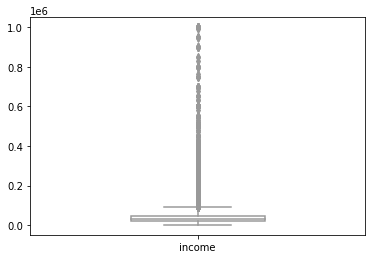

In [35]:
sns.boxplot(data = data[['income']], color = 'w', width= 0.4)

In [36]:
emission_value_q3(data, 'income')['income'].value_counts()[:20]

50000     6742
60000     3818
70000     2421
100000    2056
80000     1951
55000     1176
150000    1003
120000     789
65000      773
90000      749
75000      544
200000     500
85000      319
48000      283
300000     248
250000     214
110000     213
52000      211
130000     194
95000      146
Name: income, dtype: int64

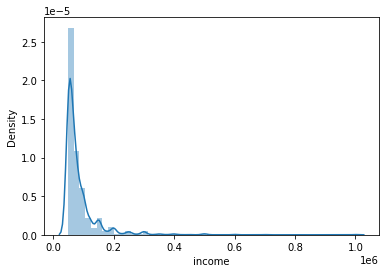

In [37]:
sns.distplot(emission_value_q3(data, 'income')['income'], kde = True, rug = False)

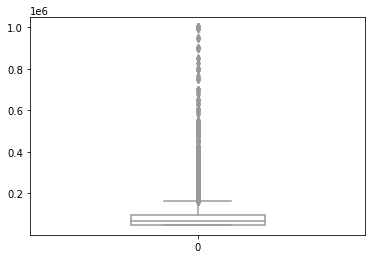

In [38]:
sns.boxplot(data = emission_value_q3(data, 'income')['income'], color = 'w', width= 0.4)

Примем границу выбросов доход в 200 000 в год. Все значения предполагаемых выбросов заменим на median

In [39]:
data['income'] = data['income'].apply(lambda x: data['income'].median() if x > 200000 else x)

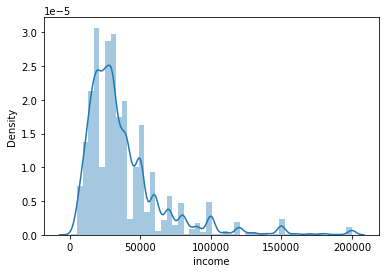

In [40]:
sns.distplot(data['income'], kde = True, rug = False)

Распределение в столбце income имеют тяжелый правый хвост, прологарифмируем данные

In [41]:
data['income'] = data['income'].apply(lambda x : np.log(x))

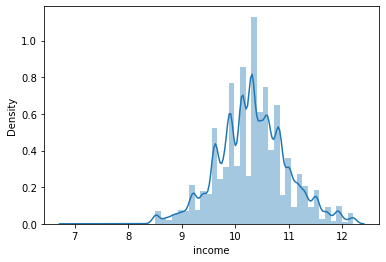

In [42]:
sns.distplot(data['income'], kde = True, rug = False)

Распределение приблизилось к нормальному закону.

### Зависимость числовых данных
Оценим зависимость числовых признаков с помощью корреляции Пирсона

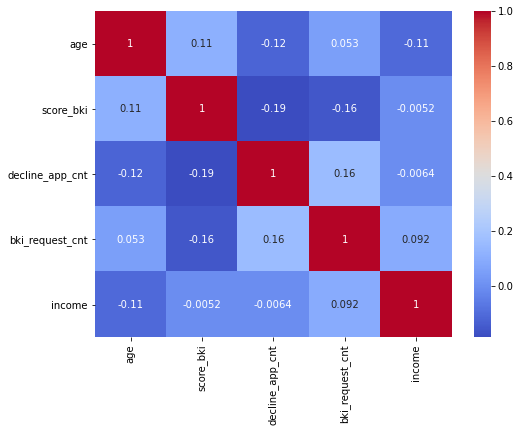

In [43]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data[num_cols].corr(),annot = True, cmap = 'coolwarm')

#### Значимость числовых переменных

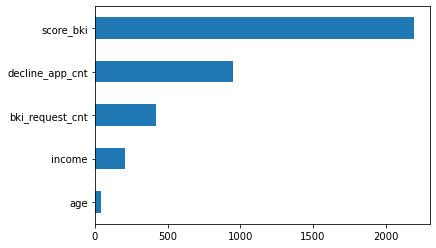

In [44]:
imp_num = pd.Series(f_classif(data[num_cols], data['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

### Переменная времени

In [45]:
data['app_date'] = pd.to_datetime(data.app_date, format='%d%b%Y')
data['app_date'].sample(5)

73642    2014-02-24
7994     2014-04-05
54996    2014-03-16
102266   2014-02-12
64413    2014-02-01
Name: app_date, dtype: datetime64[ns]

In [46]:
# Проверка года подачи заявки
data['app_date'].dt.year.value_counts()

2014    110148
Name: app_date, dtype: int64

In [47]:
#Проверка месяца подачи заявки
data['app_date'].dt.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: app_date, dtype: int64

В данных представлены заявки за 4 месяца. Создадим столбец с категориальными данными. Примем: 1 - подача заявки в январе, 2 - в феврале и т.д.

In [48]:
data['month_app_date'] = data['app_date'].apply(lambda x: x.month)

In [49]:
# добавим month_app_data в список с категориальными данными
cat_cols.append('month_app_date')
cat_cols

['education',
 'home_address',
 'work_address',
 'first_time',
 'sna',
 'region_rating',
 'cat_decline_app_cnt',
 'cat_bki_request_cnt',
 'month_app_date']

### Категориальные переменные

In [50]:
data[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   education            109670 non-null  object
 1   home_address         110148 non-null  int64 
 2   work_address         110148 non-null  int64 
 3   first_time           110148 non-null  int64 
 4   sna                  110148 non-null  int64 
 5   region_rating        110148 non-null  int64 
 6   cat_decline_app_cnt  110148 non-null  int64 
 7   cat_bki_request_cnt  110148 non-null  int64 
 8   month_app_date       110148 non-null  int64 
dtypes: int64(8), object(1)
memory usage: 7.6+ MB


В столбце education присутствуют пропуски. Для дальнейшей работы нужно заполнить пропуски и зашифровать данные (перевести в формат int)

#### Данные в столбце education

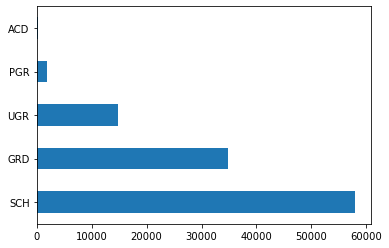

In [51]:
#распределение данных
data['education'].value_counts().plot.barh()

In [52]:
# заполним пропуски значением 'No_inf
data['education'] = data['education'].fillna('No_inf')

In [53]:
# шифруем переменные в education
dict_prise = {'No_inf' : 0,'ACD': 1,  'PGR' : 2, 'UGR' : 3, 'GRD': 4, 'SCH': 5}
data['education'] = data['education'].replace(to_replace = dict_prise)
data['education'].value_counts()

5    57998
4    34768
3    14748
2     1865
0      478
1      291
Name: education, dtype: int64

#### Зависимость категориальных переменных

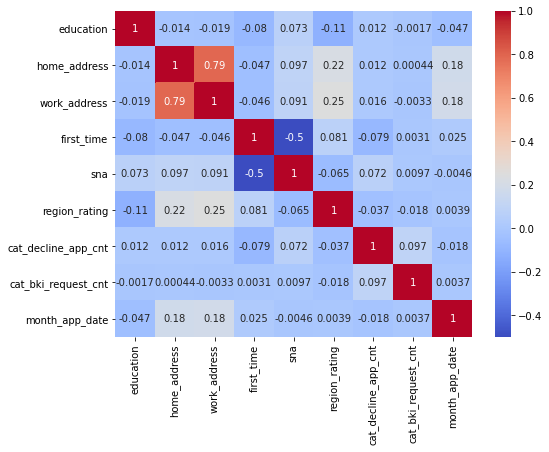

In [54]:
fig, ax = plt.subplots(1,1, figsize = (8,6))
ax = sns.heatmap(data[cat_cols].corr(method = 'spearman'),annot = True, cmap = 'coolwarm')

Найдена большая корреляционная зависимость между данными в столбцах work_adress и home_address (место работы рядом с местом проживания), sna и first_time (чем раньше клиент обратился в банк, тем больше известно о связи заемщика с клиентами банка). Решение об исключении данных для обучения модели будем принимать при дальнейшем анализе.
У данных в столбце education максимальная отрицательная корреляция с данными в столбце region_rating.  Можно использовать данную связь для уменьшения значений "No_inf"

### Бинарные признаки

In [55]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   sex               110148 non-null  object
 1   car               110148 non-null  object
 2   car_type          110148 non-null  object
 3   foreign_passport  110148 non-null  object
 4   good_work         110148 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.2+ MB


все столбцы, кроме good_work, имеют тип object. Используем LabelEncoder для кодирования бинарных переменных

In [56]:
# Для бинарных признаков мы будем использовать LabelEncoder
label_encoder = LabelEncoder()

for column in ['sex', 'car', 'car_type', 'foreign_passport']:
    data[column] = label_encoder.fit_transform(data[column])

In [57]:
data[bin_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype
---  ------            --------------   -----
 0   sex               110148 non-null  int64
 1   car               110148 non-null  int64
 2   car_type          110148 non-null  int64
 3   foreign_passport  110148 non-null  int64
 4   good_work         110148 non-null  int64
dtypes: int64(5)
memory usage: 4.2 MB


### Значимость категориальных и бинарных переменных 

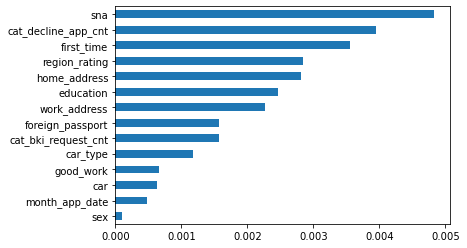

In [58]:
imp_cat = pd.Series(mutual_info_classif(data[bin_cols + cat_cols], data['default'], discrete_features =True), index = bin_cols + cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

# Подготовка данных

In [59]:
# исключим столбцы decline_app_cnt и bki_request_cnt из числовых признаков.
#Дальше используем категориальные данные в столбцах cat_decline_app_cnt и cat_bki_request_cnt)
num_cols.remove('decline_app_cnt')
num_cols.remove('bki_request_cnt')

In [60]:
num_cols

['age', 'score_bki', 'income']

In [61]:
bin_cols

['sex', 'car', 'car_type', 'foreign_passport', 'good_work']

In [62]:
cat_cols

['education',
 'home_address',
 'work_address',
 'first_time',
 'sna',
 'region_rating',
 'cat_decline_app_cnt',
 'cat_bki_request_cnt',
 'month_app_date']

Выделим тестовую часть из data

In [63]:
train_data = data.query('sample == 1').drop(['sample'], axis=1)
test_data = data.query('sample == 0').drop(['sample'], axis=1)

### Категориальные признаки
Применем OneHotEncoder для кодировки

In [64]:
X_cat_train = OneHotEncoder(sparse = False).fit_transform(train_data[cat_cols].values)
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test_data[cat_cols].values)

In [65]:
X_cat_train.shape

(73799, 39)

In [66]:
X_cat_test.shape

(36349, 39)

### Числовые переменные
Стандартизируем с помощью StandartScale

In [67]:
X_num_train = StandardScaler().fit_transform(train_data[num_cols].values)
X_num_test = StandardScaler().fit_transform(test_data[num_cols].values)

In [68]:
X_num_train.shape

(73799, 3)

In [69]:
X_num_test.shape

(36349, 3)

### Объединяем данные

In [70]:
X = np.hstack([X_num_train, train_data[bin_cols].values, X_cat_train])
X_test = np.hstack([X_num_test, test_data[bin_cols].values, X_cat_test])

In [71]:
X.shape

(73799, 47)

In [72]:
X_test.shape

(36349, 47)

In [73]:
y = train_data['default'].values 

In [74]:
y.shape

(73799,)

#### Разделим данные для обучения

In [75]:
# разделим данные
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=RANDOM_SEED)

In [76]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X_train = np.hstack([np.ones(X_train.shape[0])[:, np.newaxis], X_train])
X_val = np.hstack([np.ones(X_val.shape[0])[:, np.newaxis], X_val])

## Обучение модели

In [77]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

#### Roc-анализ

In [78]:
probs = model.predict_proba(X_val)
probs = probs[:,1]

In [79]:
fpr, tpr, threshold = roc_curve(y_val, probs)
roc_auc = roc_auc_score(y_val, probs)

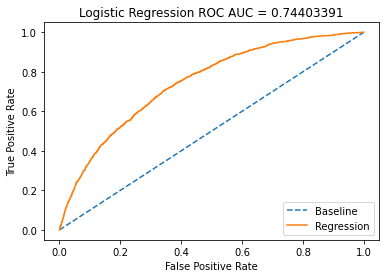

In [80]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.8f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

Confusion matrix

In [81]:
y_predicted = model.predict(X_val)

In [82]:
confusion_matrix(y_val, y_predicted)

array([[12870,    63],
       [ 1785,    42]])

#### Проверка на переобучение

In [138]:
y_predicted_train = model.predict(X_train)
f1_train = f1_score(y_train, y_predicted_train)
f1_train

0.0540946656649136

In [139]:
f1_val = f1_score(y_val, y_predicted)
f1_val

0.043478260869565216

Значение ф-ции ошибки на валидации меньше, чем на обучении. Переобучения нет

## Регуляризация

In [83]:
from sklearn.model_selection import GridSearchCV

In [84]:
# Добавим типы регуляризации
penalty = ['l1', 'l2']

In [85]:
# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 3, 100)

In [86]:
# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

In [87]:
# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

In [88]:
reg_model = clf.fit(X_train, y_train)

In [89]:
# View best hyperparameters
print('Лучшее Penalty:', reg_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', reg_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l2
Лучшее C: 1.4174741629268053


In [90]:
model_reg = LogisticRegression(penalty ='l2', C = 1.417)
model_reg.fit(X_train, y_train)

LogisticRegression(C=1.417)

### Roc-анализ

In [91]:
probs_2 = model_reg.predict_proba(X_val)
probs_2 = probs_2[:,1]

In [92]:
fpr, tpr, threshold = roc_curve(y_val, probs_2)
roc_auc_2 = roc_auc_score(y_val, probs_2)

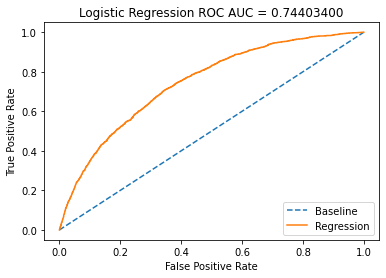

In [93]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.8f' % roc_auc_2)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [94]:
y_predicted_2 = model_reg.predict(X_val)

In [95]:
confusion_matrix(y_val, y_predicted_2)

array([[12870,    63],
       [ 1785,    42]])

## Oversampling

Рассмотрим DataFrame массивы X и y (данные готовы к обучению). Для удобства собирем в Data Frame


In [96]:
data_oversampling = pd.DataFrame(X)

In [97]:
data_oversampling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 47 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       73799 non-null  float64
 1   1       73799 non-null  float64
 2   2       73799 non-null  float64
 3   3       73799 non-null  float64
 4   4       73799 non-null  float64
 5   5       73799 non-null  float64
 6   6       73799 non-null  float64
 7   7       73799 non-null  float64
 8   8       73799 non-null  float64
 9   9       73799 non-null  float64
 10  10      73799 non-null  float64
 11  11      73799 non-null  float64
 12  12      73799 non-null  float64
 13  13      73799 non-null  float64
 14  14      73799 non-null  float64
 15  15      73799 non-null  float64
 16  16      73799 non-null  float64
 17  17      73799 non-null  float64
 18  18      73799 non-null  float64
 19  19      73799 non-null  float64
 20  20      73799 non-null  float64
 21  21      73799 non-null  float64
 22

In [98]:
series_y = pd.Series(y)

In [99]:
data_oversampling['47'] = series_y

In [100]:
data_oversampling.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 48 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       73799 non-null  float64
 1   1       73799 non-null  float64
 2   2       73799 non-null  float64
 3   3       73799 non-null  float64
 4   4       73799 non-null  float64
 5   5       73799 non-null  float64
 6   6       73799 non-null  float64
 7   7       73799 non-null  float64
 8   8       73799 non-null  float64
 9   9       73799 non-null  float64
 10  10      73799 non-null  float64
 11  11      73799 non-null  float64
 12  12      73799 non-null  float64
 13  13      73799 non-null  float64
 14  14      73799 non-null  float64
 15  15      73799 non-null  float64
 16  16      73799 non-null  float64
 17  17      73799 non-null  float64
 18  18      73799 non-null  float64
 19  19      73799 non-null  float64
 20  20      73799 non-null  float64
 21  21      73799 non-null  float64
 22

In [101]:
data_ov_defolt = data_oversampling[data_oversampling['47'] == 1]

In [102]:
data_ov_defolt['47'].value_counts()

1    9372
Name: 47, dtype: int64

In [103]:
for i in range(6):
    data_oversampling = pd.concat([data_oversampling,data_ov_defolt])

In [104]:
data_oversampling['47'].value_counts()

1    65604
0    64427
Name: 47, dtype: int64

In [105]:
X_over = data_oversampling.drop(columns = ['47']).values
y_over = data_oversampling['47'].values

In [106]:
X_over.shape

(130031, 47)

In [107]:
y_over.shape

(130031,)

In [123]:
# разделим данные
X_train_ov, X_val_ov, y_train_ov, y_val_ov = train_test_split(X_over, y_over, test_size=0.20, random_state=RANDOM_SEED)

In [124]:
X_train_ov.shape

(104024, 47)

In [125]:
 X_val_ov.shape

(26007, 47)

In [126]:
y_train_ov.shape

(104024,)

In [127]:
# Добавить фиктивный столбец единиц (bias линейной модели)
X_train_ov = np.hstack([np.ones(X_train_ov.shape[0])[:, np.newaxis], X_train_ov])
X_val_ov = np.hstack([np.ones(X_val_ov.shape[0])[:, np.newaxis], X_val_ov])

In [128]:
X_train_ov.shape

(104024, 48)

In [129]:
model_ov = LogisticRegression()
model_ov.fit(X_train_ov, y_train_ov)

LogisticRegression()

### Roc-анализ

In [130]:
probs_ov = model_ov.predict_proba(X_val_ov)
probs = probs_ov[:,1]

In [132]:
fpr, tpr, threshold = roc_curve(y_val_ov, probs)
roc_auc = roc_auc_score(y_val_ov, probs)

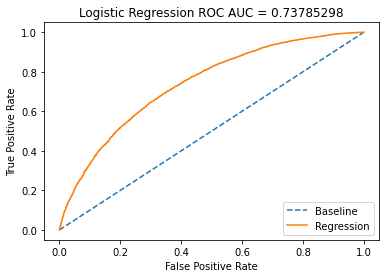

In [133]:
plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.8f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [134]:
y_predicted_ov = model_ov.predict(X_val_ov)

In [135]:
confusion_matrix(y_val_ov, y_predicted_ov)

array([[8612, 4373],
       [4147, 8875]])

Характеристика ухудшилась 